In [5]:
import pandas as pd
df = (pd.read_csv("features_v1_tail.csv", parse_dates=["timestamp"])
        .sort_values(["token", "timestamp"])
        .reset_index(drop=True))

print(df.shape)          #  ≈ 6 k rows × 35 cols
print(df.token.unique()) # 23 mid-cap Solana tokens

(6314, 35)
['$WIF' '$michi' 'ALCH' 'AVA' 'BOME' 'FWOG' 'Fartcoin' 'GIGA' 'GOAT'
 'LAUNCHCOIN' 'MEW' 'MLG' 'MOODENG' 'PONKE' 'POPCAT' 'Pnut' 'RETARDIO'
 'Ray' 'SIGMA' 'UFD' 'ZEREBRO']


In [8]:
# 2) Identify predictors (everything except timestamp, token label, and target)
feat_cols = [c for c in df.columns
             if c not in ["timestamp", "token", "return_72h"]]

# 3) Forward- then back-fill missing values within each token
df[feat_cols] = (df
    .groupby("token", group_keys=False)[feat_cols]
    .transform(lambda g: g.ffill().bfill()))

# 4) Drop any rows still missing target or predictors (should be none now)
df = df.dropna(subset=["return_72h"] + feat_cols)

# 5) Quick sanity check
assert not df[feat_cols].isna().any().any(), "Still have NaNs!"

print("Cleaned shape:", df.shape)

Cleaned shape: (5703, 35)


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.regression.quantile_regression import QuantReg as QR

# -------------------------
# 1.  Pre-processor
# -------------------------
num_cols = [c for c in feat_cols if df[c].dtype != "object"]
cat_cols = ["token", "momentum_bucket", "day_of_week"]      # treat as categoricals

pre = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
      ],
      remainder="drop")

# -------------------------
# 2.  Rolling back-test
# -------------------------
horizon       = 30    # rows in each test fold
train_window  = 120   # rows in each training window
quantiles     = [0.10, 0.50, 0.90]

fold_metrics  = []    # one row per fold × token × τ
pred_records  = []    # one row per observation in every test fold

for tkn, g in df.groupby("token"):
    g = g.reset_index(drop=True)
    for f, start in enumerate(range(0,
                                    len(g) - (train_window + horizon) + 1,
                                    horizon), start=1):
        train = g.iloc[start : start + train_window]
        test  = g.iloc[start + train_window :
                       start + train_window + horizon]

        # fit scaler / encoder **only on the training slice**
        X_train = pre.fit_transform(train)
        X_test  = pre.transform(test)
        y_train = train["return_72h"].values
        y_test  = test["return_72h"].values

        fold_preds = {}
        for q in quantiles:
            model = QR(y_train, X_train).fit(q=q, max_iter=5000)
            fold_preds[q] = model.predict(X_test)

        # post-hoc non-crossing safeguard
        fold_preds[0.10] = np.minimum(fold_preds[0.10], fold_preds[0.50])
        fold_preds[0.90] = np.maximum(fold_preds[0.90], fold_preds[0.50])

        # -------- collect per-row records --------
        for i in range(len(test)):
            pred_records.append({
                "token":      tkn,
                "timestamp":  test.iloc[i]["timestamp"],
                "fold":       f,
                "y_true":     y_test[i],
                "q10_pred":   fold_preds[0.10][i],
                "q50_pred":   fold_preds[0.50][i],
                "q90_pred":   fold_preds[0.90][i],
            })

        # -------- collect per-fold metrics --------
        inside80 = ((y_test >= fold_preds[0.10]) &
                    (y_test <= fold_preds[0.90]))
        fold_metrics.append({
            "token":     tkn,
            "fold":      f,
            "tau":      "80PI",
            "coverage":  inside80.mean(),
            "width":     (fold_preds[0.90] - fold_preds[0.10]).mean(),
        })
        for q in quantiles:
            err = y_test - fold_preds[q]
            pinball = np.maximum(q*err, (q-1)*err).mean()
            fold_metrics.append({
                "token":    tkn,
                "fold":     f,
                "tau":      q,
                "pinball":  pinball
            })

# -------------------------
# 3.  Save artefacts
# -------------------------
pd.DataFrame(pred_records).to_csv("lqr_pred_paths.csv",  index=False)
pd.DataFrame(fold_metrics).to_csv("lqr_fold_metrics.csv", index=False)

print("Finished!  Predictions → lqr_pred_paths.csv;  metrics → lqr_fold_metrics.csv")


c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (5000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\james\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (5000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarni

Finished!  Predictions → lqr_pred_paths.csv;  metrics → lqr_fold_metrics.csv


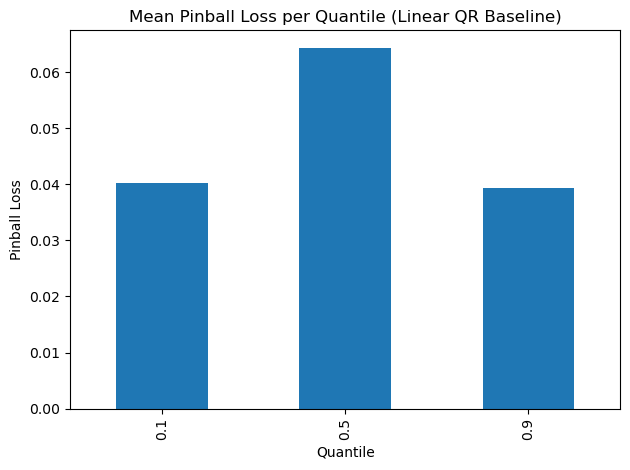

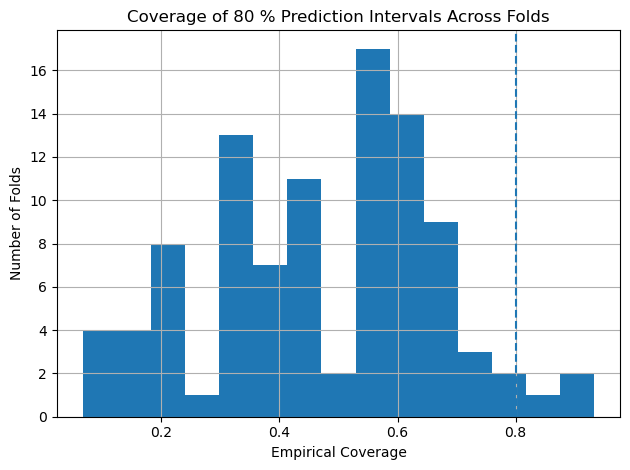

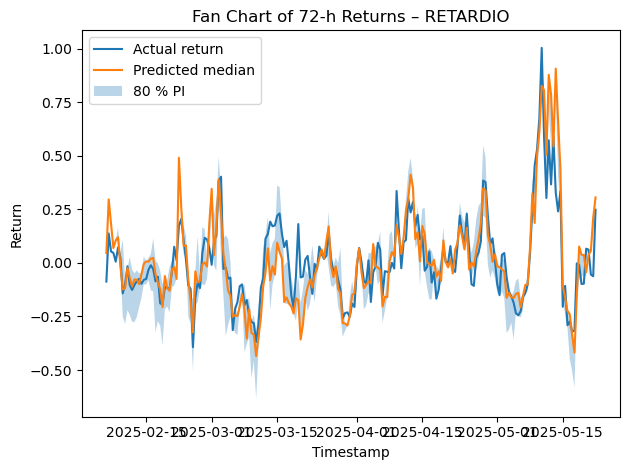

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

preds   = pd.read_csv("lqr_pred_paths.csv",  parse_dates=["timestamp"])
metrics = pd.read_csv("lqr_fold_metrics.csv")

# ---- 1. Pinball-loss bar chart ---------------------------------------------
metrics["tau_num"] = pd.to_numeric(metrics["tau"], errors="coerce")
pinball = (metrics.dropna(subset=["tau_num"])
                   .groupby("tau_num")["pinball"]
                   .mean()
                   .reindex([0.1, 0.5, 0.9]))

pinball.plot(kind="bar")
plt.title("Mean Pinball Loss per Quantile (Linear QR Baseline)")
plt.xlabel("Quantile")
plt.ylabel("Pinball Loss")
plt.tight_layout()
plt.show()

# ---- 2. 80 % PI coverage histogram -----------------------------------------
coverage = metrics[metrics["tau"] == "80PI"]["coverage"]

plt.figure()
coverage.hist(bins=15)
plt.axvline(0.8, linestyle="--")        # nominal coverage
plt.title("Coverage of 80 % Prediction Intervals Across Folds")
plt.xlabel("Empirical Coverage")
plt.ylabel("Number of Folds")
plt.tight_layout()
plt.show()

# ---- 3. Fan chart for token with longest history ---------------------------
top_token = preds["token"].value_counts().idxmax()
token_df  = preds[preds["token"] == top_token].sort_values("timestamp")

plt.figure()
plt.plot(token_df["timestamp"], token_df["y_true"], label="Actual return")
plt.plot(token_df["timestamp"], token_df["q50_pred"], label="Predicted median")
plt.fill_between(token_df["timestamp"],
                 token_df["q10_pred"], token_df["q90_pred"],
                 alpha=0.3, label="80 % PI")
plt.title(f"Fan Chart of 72-h Returns – {top_token}")
plt.xlabel("Timestamp")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()
